# E-tivity 3 : Gerard O'Rourke, Student number : 24514772
This
workbook is
for E - tivity3.It follows the following structure
1.
The
workbook
environment is setup
1.
The
next
section
has
some
EDA
related
to
this
E - tivity
1.
Each
task
for this E - tivity then follows

Setup

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import set_config
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

print(sklearn.__version__)

# needed for changing Ordinal values - see education
pd.set_option("future.no_silent_downcasting", True)
#sklearn.set_config(enable_metadata_routing=True)
set_config(transform_output='pandas')


1.6.1


#### Setup Environment
Load the data and keep a copy

In [74]:
# Load the dataset
df = pd.read_csv("./insurance.csv")

# keep a copy
df_original = df

print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (1338, 7)


EDA

In [75]:
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [76]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [77]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [78]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [ ]:
numerical_attribute = ['age','bmi','children']

categorical_attribute=['gender','smoker','region']

In [79]:
df['gender'].value_counts()

gender
male      676
female    662
Name: count, dtype: int64

In [80]:
df['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [81]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

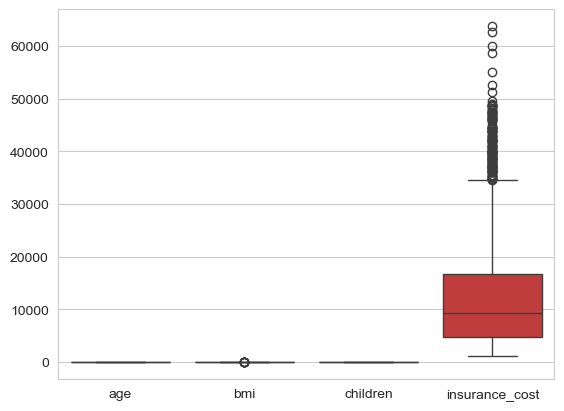

In [82]:
sns.boxplot(data=df)
plt.show()

In [ ]:
columns_no_outliers = ['age','children']
columns_outliers_and_zeros = []
columns_outliers_no_zeros=['bmi']

outliers_no_zeros_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.log)),
        ("scaler", RobustScaler())
    ]
)

outliers_and_zeros_pipeline = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.cbrt)),
        ("scaler", RobustScaler())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("outliers_no_zeros", outliers_no_zeros_pipeline, columns_outliers_no_zeros),
        ("outliers_and_zeros", outliers_and_zeros_pipeline, columns_outliers_and_zeros),
        ("no_outliers", FunctionTransformer(np.cbrt), columns_no_outliers)
    ],
    remainder="passthrough" # note there are no remaining columns in this example
)

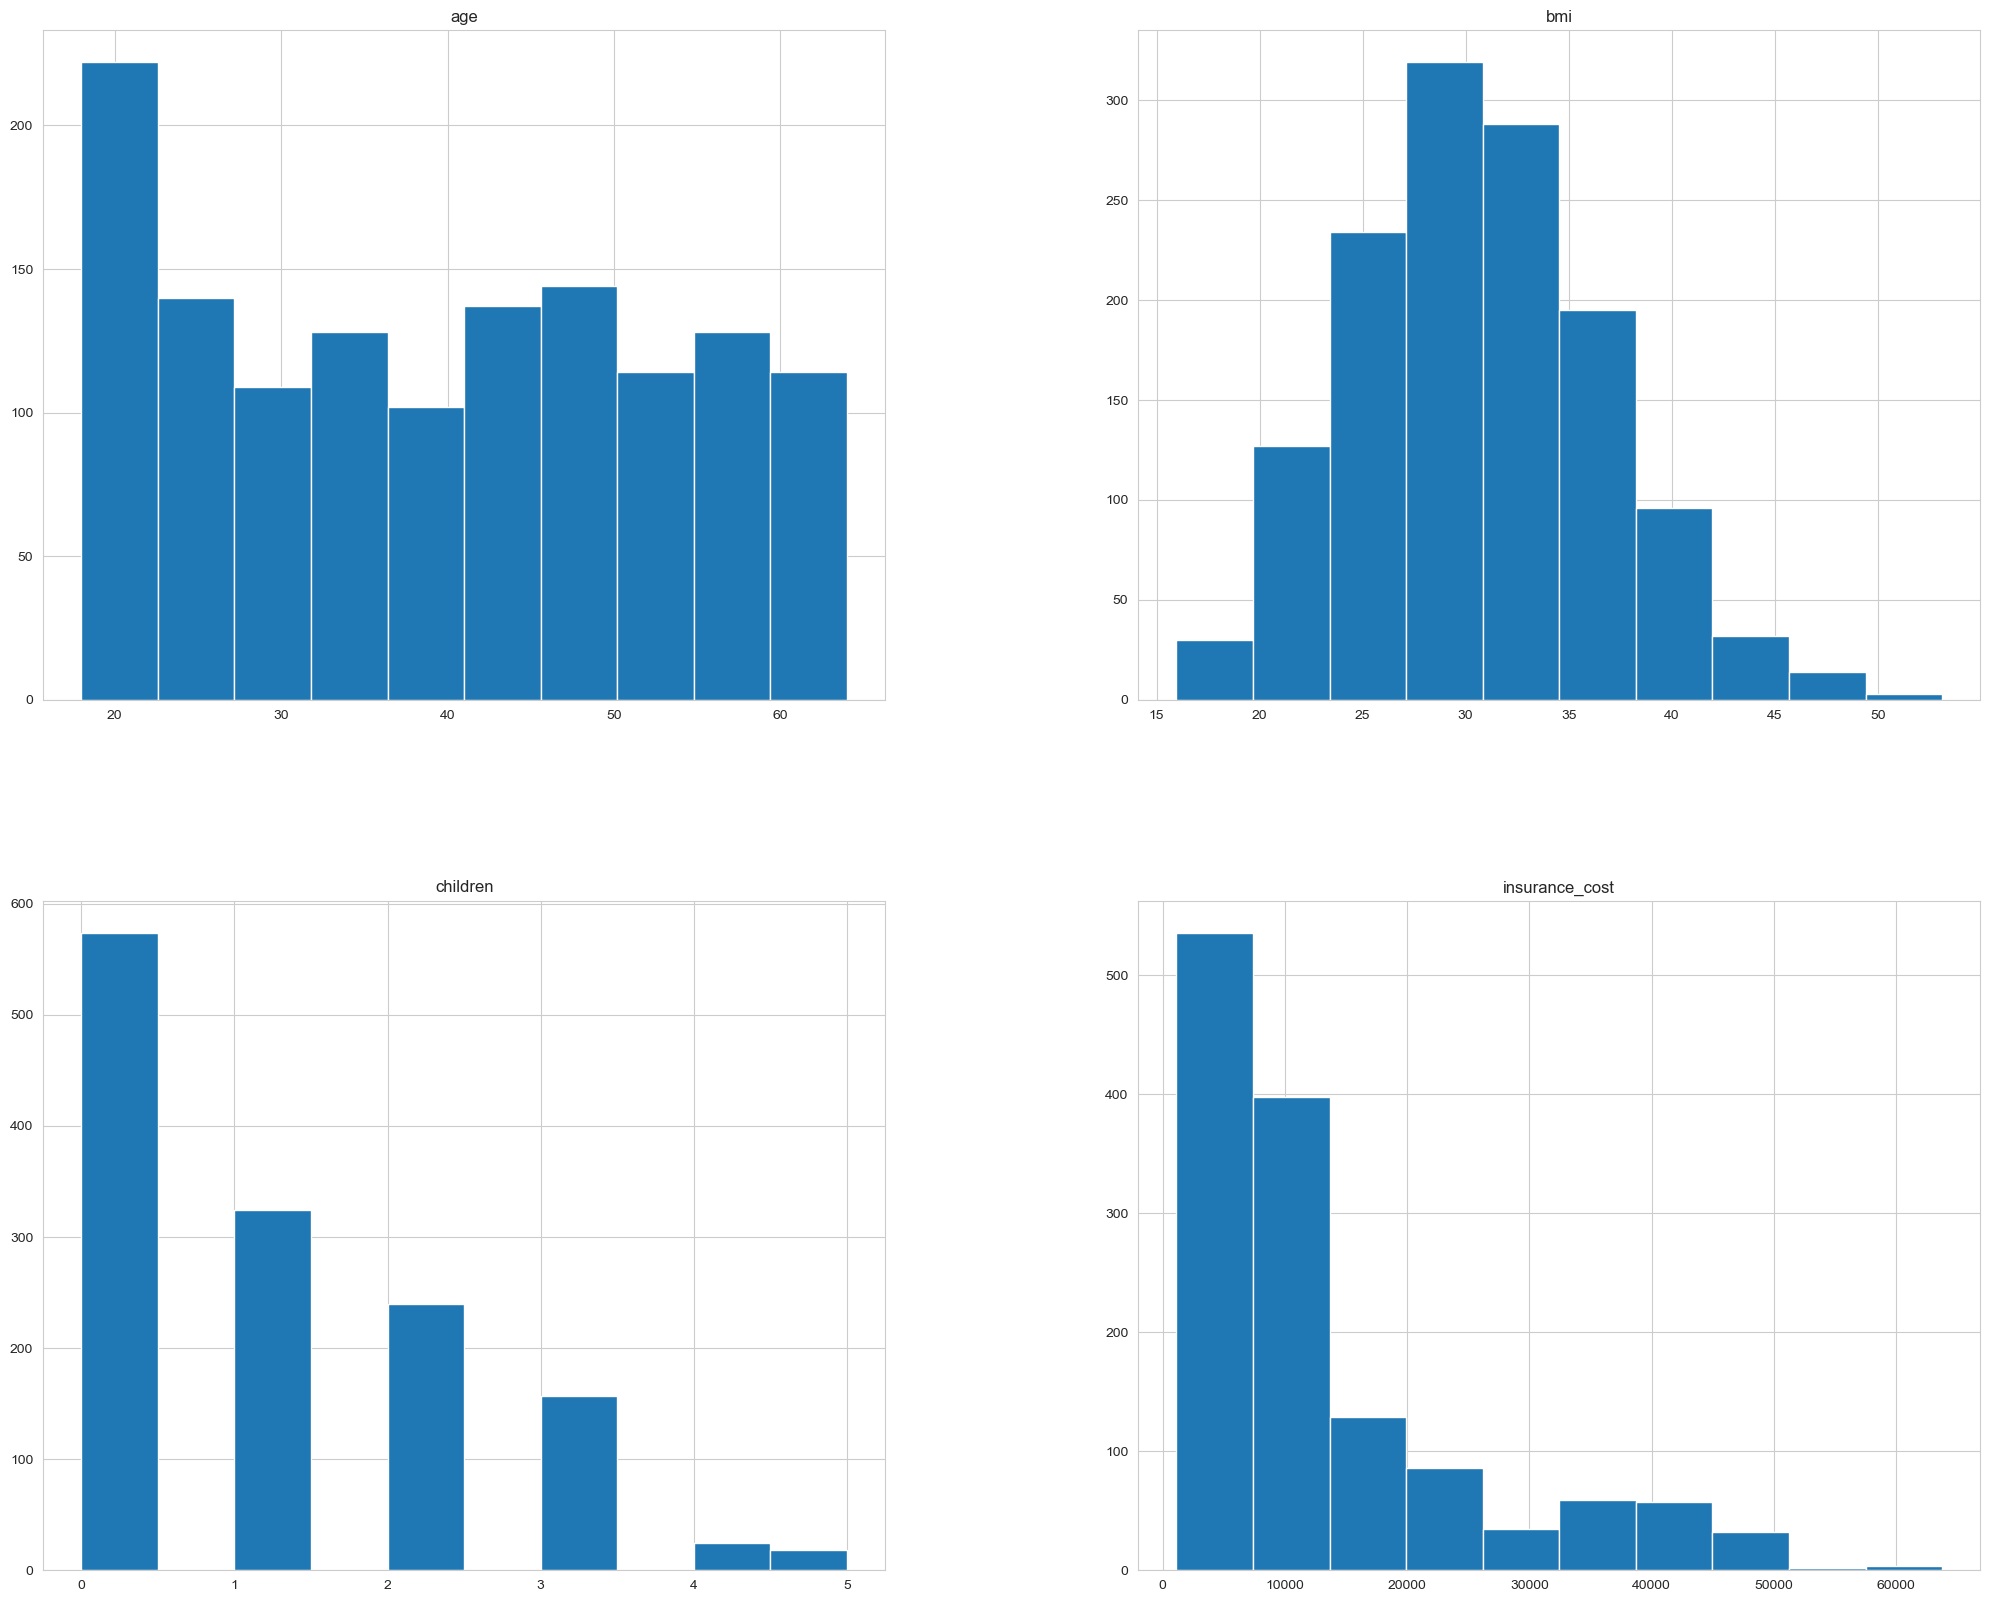

In [83]:
df.select_dtypes(include='number').hist(bins=10, figsize=(25, 20))
plt.show()

Data Preparation

In [84]:

# Step 1: Calculate the median
median_cost = df['insurance_cost'].median()
print (f"Median Cost {median_cost}")
# compare cost against median, convert True / false to 1 / 0
df['insurance_cost_binary'] = (df['insurance_cost'] > median_cost).astype(int)

y = df['insurance_cost_binary'];
X = df.drop('insurance_cost_binary',axis=1);

print(df)


Median Cost 9382.033
      age  gender     bmi  children smoker     region  insurance_cost  \
0      18    male  33.770         1     no  southeast      1725.55230   
1      18    male  34.100         0     no  southeast      1137.01100   
2      18  female  26.315         0     no  northeast      2198.18985   
3      18  female  38.665         2     no  northeast      3393.35635   
4      18  female  35.625         0     no  northeast      2211.13075   
...   ...     ...     ...       ...    ...        ...             ...   
1333   64  female  31.825         2     no  northeast     16069.08475   
1334   64  female  26.885         0    yes  northwest     29330.98315   
1335   64    male  26.410         0     no  northeast     14394.55790   
1336   64    male  36.960         2    yes  southeast     49577.66240   
1337   64    male  23.760         0    yes  southeast     26926.51440   

      insurance_cost_binary  
0                         0  
1                         0  
2           

#### Data Dictionary / Columns (https://www.kaggle.com/datasets/mirichoi0218/insurance)

1. age: age of primary beneficiary
1. sex: insurance contractor gender, female, male
1. bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
1. children: Number of children covered by health insurance / Number of dependents
1. smoker: Smoking
1. region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
1. charges: Individual medical costs billed by health insurance